In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [4]:
import pandas as pd

In [5]:
df = pd.read_csv('../data/Ads2024_IssuesbyCreative_090124-110624_HSE_AI_013026.csv')

In [6]:
# Quick-fix cleanup
df_clean = df.copy()

# Drop columns that are all missing
df_clean = df_clean.dropna(axis=1, how="all")

# Drop high-cardinality IDs and long-text columns (quick fix = remove)
drop_cols = [
    "uuid", "fp_uuid", "row_num",
    "callback_start_time", "callback_end_time", "time_ran",
    "program_name", "transcript", "title", "wmp_link",
    "alt", "secondary_target"
]
df_clean = df_clean.drop(columns=[c for c in drop_cols if c in df_clean.columns], errors="ignore")

# Treat ID-like numeric columns as categorical or drop them (quick fix = drop)
id_like = ["advertiser_id", "buy_id", "digital_source_id"]
df_clean = df_clean.drop(columns=[c for c in id_like if c in df_clean.columns], errors="ignore")

# Parse dates and extract features
date_cols = ["airdate", "tagdate", "media_date"]
for c in date_cols:
    if c in df_clean.columns:
        dt = pd.to_datetime(df_clean[c], errors="coerce")
        df_clean[f"{c}_year"] = dt.dt.year
        df_clean[f"{c}_month"] = dt.dt.month
        df_clean[f"{c}_dow"] = dt.dt.dayofweek
        df_clean = df_clean.drop(columns=c)


In [7]:
target = "tone"
X = df_clean.drop(columns=[target])
y = df_clean[target]


In [8]:
model = LogisticRegression(max_iter=2000, class_weight="balanced")


In [9]:
X.dtypes


advertiser_party        str
advertiser_type         str
advertiser              str
election_state          str
election                str
issue_1                 str
issue_2                 str
issue_3                 str
market                  str
spent               float64
grps                float64
viewers             float64
grps_55             float64
viewers_55          float64
spot_length           int64
station_state           str
station                 str
target                  str
national              int64
universe            float64
grps_18_49          float64
viewers_18_49       float64
grps_25_54          float64
viewers_25_54       float64
language                str
race                    str
media_type              str
timezone                str
daypart                 str
genre                   str
overlap               int64
universe_18_49      float64
universe_25_54      float64
universe_55_plus    float64
affiliate               str
issue_spanlang      

In [10]:

num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_exclude="number")

numeric = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric, num_selector),
        ("cat", categorical, cat_selector),
    ]
)

model = LogisticRegression(max_iter=2000, class_weight="balanced")

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])




In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:

pipe.fit(X_train, y_train)



,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [13]:
pred = pipe.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Contrast       0.94      0.98      0.96     41504
    Negative       0.99      0.97      0.98     85144
    Positive       1.00      1.00      1.00     61905

    accuracy                           0.98    188553
   macro avg       0.97      0.98      0.98    188553
weighted avg       0.98      0.98      0.98    188553



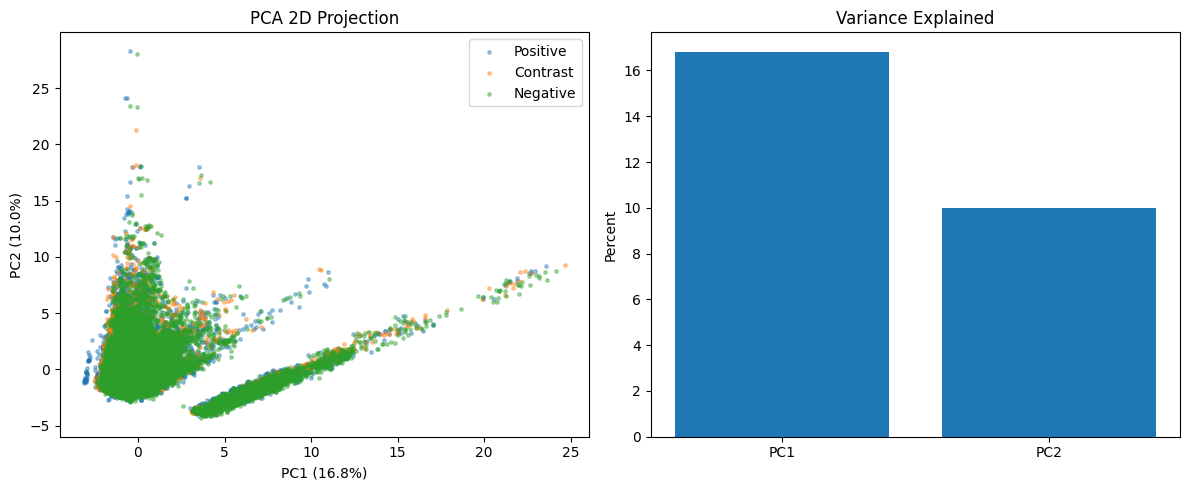

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit

# Sample for speed
sample_size = 50000
sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - sample_size/len(df_clean), random_state=42)
idx, _ = next(sss.split(df_clean, df_clean["tone"]))
df_s = df_clean.iloc[idx].copy()

target = "tone"
X = df_s.drop(columns=[target])
y = df_s[target]

num_selector = make_column_selector(dtype_include="number")
cat_selector = make_column_selector(dtype_exclude="number")

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]), num_selector),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]), cat_selector),
])

# Transform to numeric matrix
X_proc = preprocess.fit_transform(X)
X_dense = X_proc.toarray() if hasattr(X_proc, "toarray") else X_proc

# PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_dense)
var = pca.explained_variance_ratio_

# Plot scatter + explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter
ax = axes[0]
for label in y.unique():
    mask = (y == label)
    ax.scatter(X_2d[mask, 0], X_2d[mask, 1], s=6, alpha=0.4, label=label)
ax.set_title("PCA 2D Projection")
ax.set_xlabel(f"PC1 ({var[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({var[1]*100:.1f}%)")
ax.legend()

# Variance explained
ax = axes[1]
ax.bar(["PC1", "PC2"], var * 100)
ax.set_title("Variance Explained")
ax.set_ylabel("Percent")

plt.tight_layout()
plt.show()


In [15]:
# leaky_cols = ["tagdate","fp_uuid","alt","transcript","wmp_link","uuid","row_num"]
# # X = df_clean.drop(columns=leaky_cols + [target], errors="ignore")
# # y = df_clean[target]
# "uuid", "fp_uuid", "row_num",
#     "callback_start_time", "callback_end_time", "time_ran",
#     "program_name", "transcript", "title", "wmp_link",


In [18]:
import pandas as pd

def leakage_score(df, col, target="tone"):
    g = df[[col, target]].dropna()
    # For each value of col, how many target classes appear?
    nunique_per_val = g.groupby(col)[target].nunique()
    # If most values map to only 1 class, that’s suspicious
    score = (nunique_per_val <= 1).mean()
    return score, nunique_per_val

score, nunique_per_val = leakage_score(df_clean, "alt", "tone")
print("Leakage score (1.0 = perfect leakage):", score)


KeyError: "['alt'] not in index"

In [ ]:
cols = df_clean.columns.drop("tone")
scores = []
for c in cols:
    try:
        s, _ = leakage_score(df_clean, c, "tone")
        scores.append((c, s))
    except Exception:
        pass

leaky = sorted(scores, key=lambda x: -x[1])[:15]
leaky


[('alt', np.float64(1.0)),
 ('secondary_target', np.float64(0.9848484848484849)),
 ('spent', np.float64(0.595866657229811)),
 ('advertiser', np.float64(0.5826771653543307)),
 ('special', np.float64(0.5)),
 ('target', np.float64(0.4642857142857143)),
 ('election', np.float64(0.4550898203592814)),
 ('tagdate_month', np.float64(0.45454545454545453)),
 ('race', np.float64(0.44171779141104295)),
 ('station', np.float64(0.3628808864265928)),
 ('market', np.float64(0.3271604938271605)),
 ('universe', np.float64(0.3125)),
 ('universe_18_49', np.float64(0.3125)),
 ('universe_25_54', np.float64(0.3125)),
 ('universe_55_plus', np.float64(0.3125))]

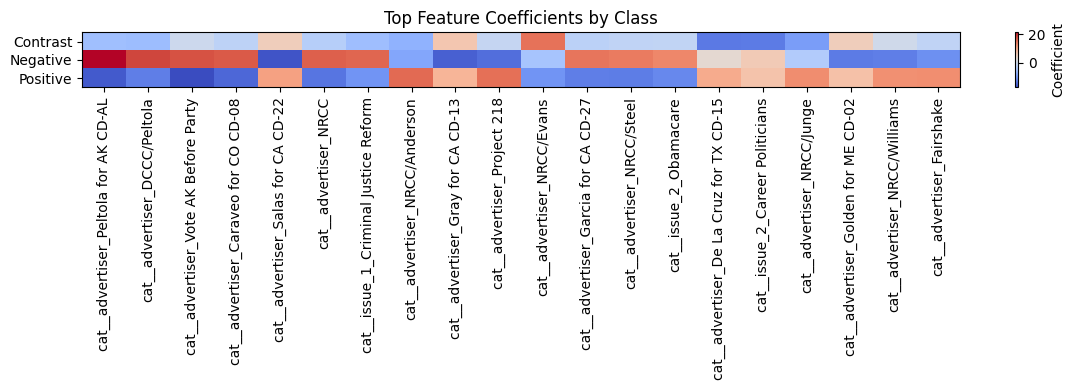

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fit if not already
# pipe.fit(X_train, y_train)

# Get feature names after preprocessing
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
coef = pipe.named_steps["model"].coef_  # shape: [n_classes, n_features]

# Build a DataFrame for easy slicing
coef_df = pd.DataFrame(coef, index=pipe.named_steps["model"].classes_, columns=feature_names)

# Pick top features by absolute weight (overall)
top_k = 20
top_features = coef_df.abs().max(axis=0).sort_values(ascending=False).head(top_k).index
coef_top = coef_df[top_features]

# Plot heatmap-like matrix
plt.figure(figsize=(12, 4))
plt.imshow(coef_top, aspect="auto", cmap="coolwarm")
plt.colorbar(label="Coefficient")
plt.yticks(range(len(coef_top.index)), coef_top.index)
plt.xticks(range(len(coef_top.columns)), coef_top.columns, rotation=90)
plt.title("Top Feature Coefficients by Class")
plt.tight_layout()
plt.show()


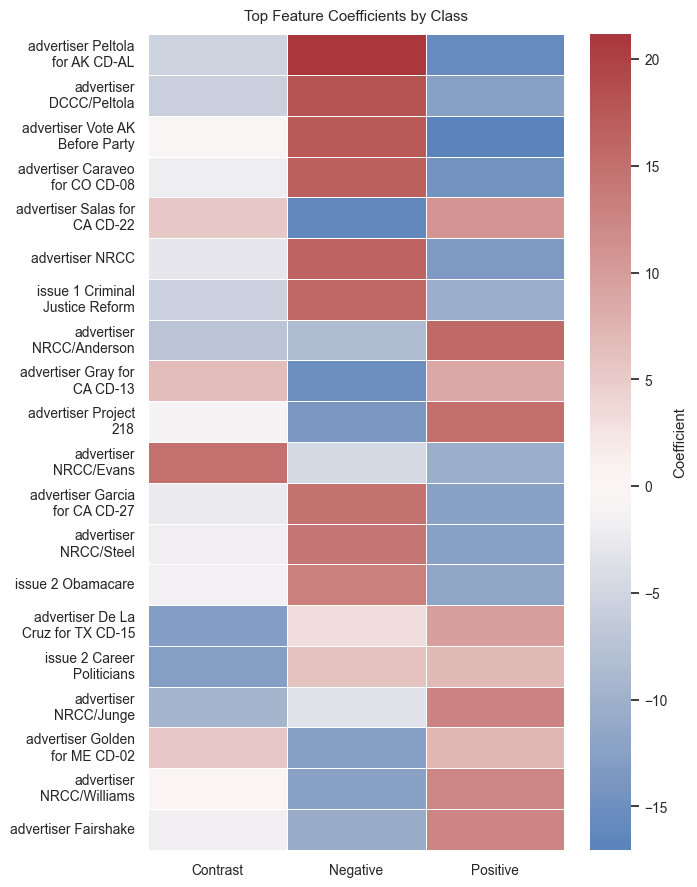

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

# after you build coef_df
# coef_df = pd.DataFrame(coef, index=classes, columns=feature_names)

top_k = 20
top_features = coef_df.abs().max(axis=0).sort_values(ascending=False).head(top_k).index
coef_top = coef_df[top_features].T  # features on rows, classes on columns

def clean_name(s):
    s = s.replace("cat__", "").replace("num__", "")
    s = s.replace("onehot__", "")
    s = s.replace("_", " ")
    return textwrap.fill(s, 20)

coef_top.index = [clean_name(c) for c in coef_top.index]

sns.set_theme(style="white", font_scale=0.9)
plt.figure(figsize=(7, 0.35 * top_k + 2))

ax = sns.heatmap(
    coef_top,
    cmap="vlag",
    center=0,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Coefficient"}
)

ax.set_title("Top Feature Coefficients by Class", pad=10)
ax.set_xlabel("")
ax.set_ylabel("")
plt.tight_layout()
plt.show()


In [21]:
feature_names = pipe.named_steps["preprocess"].get_feature_names_out()
coef = pipe.named_steps["model"].coef_

coef_df = pd.DataFrame(coef, index=pipe.named_steps["model"].classes_, columns=feature_names)

# Top numeric features by absolute weight
num_cols = [c for c in coef_df.columns if c.startswith("num__")]
top_num = coef_df[num_cols].abs().max(axis=0).sort_values(ascending=False).head(20)
top_num


num__district            1.451959
num__tagdate_month       1.093272
num__spot_length         0.606736
num__tagdate_dow         0.576014
num__issue_spanlang      0.406350
num__universe_55_plus    0.293424
num__universe_18_49      0.258517
num__grps                0.242236
num__grps_55             0.190409
num__airdate_month       0.161807
num__national            0.136970
num__viewers_25_54       0.136079
num__viewers_18_49       0.123942
num__primary             0.118098
num__universe_25_54      0.111387
num__universe            0.106881
num__special             0.101780
num__general             0.098378
num__grps_25_54          0.097581
num__media_date_month    0.079778
dtype: float64